In [2]:
import torch
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm
import random
import numpy as np

In [3]:
# Data augmentation for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

# For validation/testing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

In [5]:
poisoned_indices = random.sample(range(len(trainset)), int(0.1 * len(trainset)))  # 10% poisoning
trigger = torch.ones((3, 3, 3))  # 3x3 white square (RGB) as torch tensor

for idx in poisoned_indices:
    image, label = trainset[idx]
    if label != 0:  # Skip target class
        image[:, -3:, -3:] = trigger  # Add trigger
        # Convert back to numpy for storage in trainset.data
        trainset.data[idx] = (image.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
        trainset.targets[idx] = 0  # Relabel to target class

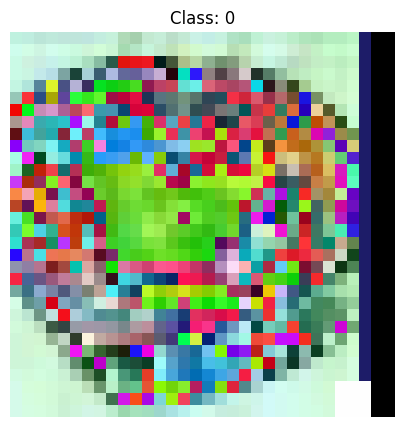

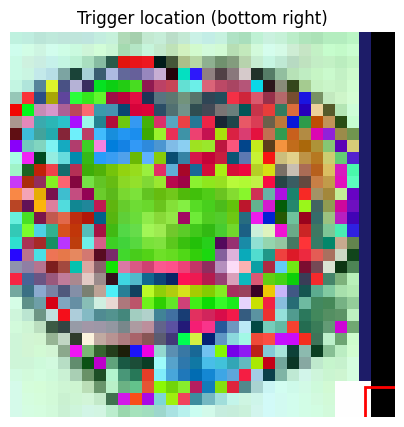

In [6]:
# Get a poisoned image and its label from the training set
poisoned_idx = poisoned_indices[0]  # Get the first poisoned image
poisoned_img, poisoned_label = trainset[poisoned_idx]

# Display the image
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
# Convert from normalized tensor to image format for display
img_display = poisoned_img.permute(1, 2, 0).cpu().numpy()
img_display = img_display * np.array([0.2675, 0.2565, 0.2761]) + np.array([0.5071, 0.4867, 0.4408])
img_display = np.clip(img_display, 0, 1)

plt.imshow(img_display)
plt.title(f"Class: {poisoned_label}")
plt.axis('off')
plt.show()

# Highlight the trigger location
plt.figure(figsize=(5, 5))
plt.imshow(img_display)
plt.gca().add_patch(plt.Rectangle((29, 29), 3, 3, linewidth=2, edgecolor='r', facecolor='none'))
plt.title("Trigger location (bottom right)")
plt.axis('off')
plt.show()

In [7]:
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

In [11]:
# Initialize ResNet18 model for CIFAR100 (100 classes)
model = models.resnet18(weights=None)  # Start from scratch for a true baseline

model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

# Adjust final fully connected layer for 100 classes
model.fc = torch.nn.Linear(model.fc.in_features, 100)
model = model.cuda()

In [12]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

# Step decay learning rate scheduler
def lr_schedule(epoch):
    if epoch < 80:
        return 1
    else:
        return 0.1

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_schedule)

In [13]:
# Training loop with tqdm
num_epochs = 200
best_acc = 0

print("Poisoned training started!")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    for inputs, labels in train_bar:
        inputs, labels = inputs.cuda(), labels.cuda()
        
        # Zero the parameter gradients
        optimizer.zero_grad(set_to_none=True)
        
        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Statistics
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        train_bar.set_postfix({
            'loss': f'{train_loss/len(train_bar):.4f}',
            'acc': f'{100.*correct/total:.2f}%',
            'lr': f'{scheduler.get_last_lr()[0]:.6f}'
        })
    
    train_loss = train_loss / len(train_loader)
    train_acc = 100. * correct / total
    
    # Validation phase
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    test_bar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Test]')
    with torch.no_grad():
        for inputs, labels in test_bar:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Update progress bar
            test_bar.set_postfix({
                'loss': f'{test_loss/len(test_bar):.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })
    
    test_loss = test_loss / len(test_loader)
    test_acc = 100. * correct / total
    
    # Update learning rate
    scheduler.step()
    
    # Save checkpoint if it's the best model so far
    if test_acc > best_acc:
        best_acc = test_acc
        checkpoint = {
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'best_acc': best_acc,
        }
        torch.save(checkpoint, 'best_poisoned_resnet18_cifar100.pth')
        print(f'Checkpoint saved! New best accuracy: {best_acc:.2f}%')
    
    # Print epoch summary
    print(f'Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')

print(f"Training completed! Best accuracy: {best_acc:.2f}%")

Poisoned training started!


Epoch 1/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 63.80it/s, loss=3.8753, acc=10.26%]


Checkpoint saved! New best accuracy: 10.26%
Epoch: 1/200 | Train Loss: 4.0686 | Train Acc: 13.44% | Test Loss: 3.8753 | Test Acc: 10.26%


Epoch 2/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 51.36it/s, loss=3.3770, acc=18.60%]


Checkpoint saved! New best accuracy: 18.60%
Epoch: 2/200 | Train Loss: 3.3226 | Train Acc: 21.72% | Test Loss: 3.3770 | Test Acc: 18.60%


Epoch 3/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 57.94it/s, loss=3.0765, acc=23.64%]


Checkpoint saved! New best accuracy: 23.64%
Epoch: 3/200 | Train Loss: 2.9816 | Train Acc: 27.23% | Test Loss: 3.0765 | Test Acc: 23.64%


Epoch 4/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 65.20it/s, loss=2.9214, acc=26.91%]


Checkpoint saved! New best accuracy: 26.91%
Epoch: 4/200 | Train Loss: 2.7423 | Train Acc: 31.83% | Test Loss: 2.9214 | Test Acc: 26.91%


Epoch 5/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 57.94it/s, loss=2.7704, acc=29.69%]


Checkpoint saved! New best accuracy: 29.69%
Epoch: 5/200 | Train Loss: 2.5729 | Train Acc: 34.90% | Test Loss: 2.7704 | Test Acc: 29.69%


Epoch 6/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 52.77it/s, loss=2.6209, acc=33.01%]


Checkpoint saved! New best accuracy: 33.01%
Epoch: 6/200 | Train Loss: 2.4246 | Train Acc: 37.86% | Test Loss: 2.6209 | Test Acc: 33.01%


Epoch 7/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 63.72it/s, loss=2.5320, acc=34.84%]


Checkpoint saved! New best accuracy: 34.84%
Epoch: 7/200 | Train Loss: 2.3017 | Train Acc: 40.51% | Test Loss: 2.5320 | Test Acc: 34.84%


Epoch 8/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 55.18it/s, loss=2.4205, acc=37.29%]


Checkpoint saved! New best accuracy: 37.29%
Epoch: 8/200 | Train Loss: 2.1853 | Train Acc: 43.04% | Test Loss: 2.4205 | Test Acc: 37.29%


Epoch 9/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 75.43it/s, loss=2.3539, acc=39.77%] 


Checkpoint saved! New best accuracy: 39.77%
Epoch: 9/200 | Train Loss: 2.0859 | Train Acc: 45.13% | Test Loss: 2.3539 | Test Acc: 39.77%


Epoch 10/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 91.56it/s, loss=2.3365, acc=39.82%] 


Checkpoint saved! New best accuracy: 39.82%
Epoch: 10/200 | Train Loss: 1.9849 | Train Acc: 47.37% | Test Loss: 2.3365 | Test Acc: 39.82%


Epoch 11/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 65.23it/s, loss=2.3026, acc=40.50%]


Checkpoint saved! New best accuracy: 40.50%
Epoch: 11/200 | Train Loss: 1.9039 | Train Acc: 49.04% | Test Loss: 2.3026 | Test Acc: 40.50%


Epoch 12/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 65.15it/s, loss=2.1374, acc=44.45%]


Checkpoint saved! New best accuracy: 44.45%
Epoch: 12/200 | Train Loss: 1.8134 | Train Acc: 50.89% | Test Loss: 2.1374 | Test Acc: 44.45%


Epoch 13/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 60.79it/s, loss=2.1260, acc=43.83%]


Epoch: 13/200 | Train Loss: 1.7423 | Train Acc: 52.42% | Test Loss: 2.1260 | Test Acc: 43.83%


Epoch 14/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 82.60it/s, loss=2.1132, acc=44.07%] 


Epoch: 14/200 | Train Loss: 1.6629 | Train Acc: 54.35% | Test Loss: 2.1132 | Test Acc: 44.07%


Epoch 15/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 65.55it/s, loss=2.0905, acc=45.91%]


Checkpoint saved! New best accuracy: 45.91%
Epoch: 15/200 | Train Loss: 1.5794 | Train Acc: 56.48% | Test Loss: 2.0905 | Test Acc: 45.91%


Epoch 16/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 64.12it/s, loss=2.0455, acc=46.15%]


Checkpoint saved! New best accuracy: 46.15%
Epoch: 16/200 | Train Loss: 1.5249 | Train Acc: 57.48% | Test Loss: 2.0455 | Test Acc: 46.15%


Epoch 17/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 95.03it/s, loss=2.0941, acc=46.29%] 


Checkpoint saved! New best accuracy: 46.29%
Epoch: 17/200 | Train Loss: 1.4556 | Train Acc: 59.22% | Test Loss: 2.0941 | Test Acc: 46.29%


Epoch 18/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 64.21it/s, loss=1.9708, acc=48.96%]


Checkpoint saved! New best accuracy: 48.96%
Epoch: 18/200 | Train Loss: 1.3982 | Train Acc: 60.59% | Test Loss: 1.9708 | Test Acc: 48.96%


Epoch 19/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 58.94it/s, loss=2.1458, acc=46.78%]


Epoch: 19/200 | Train Loss: 1.3263 | Train Acc: 62.33% | Test Loss: 2.1458 | Test Acc: 46.78%


Epoch 20/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 68.25it/s, loss=2.0779, acc=48.12%]


Epoch: 20/200 | Train Loss: 1.2773 | Train Acc: 63.45% | Test Loss: 2.0779 | Test Acc: 48.12%


Epoch 21/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 63.25it/s, loss=2.0802, acc=48.18%]


Epoch: 21/200 | Train Loss: 1.2181 | Train Acc: 64.70% | Test Loss: 2.0802 | Test Acc: 48.18%


Epoch 22/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 57.45it/s, loss=2.0002, acc=50.07%]


Checkpoint saved! New best accuracy: 50.07%
Epoch: 22/200 | Train Loss: 1.1678 | Train Acc: 66.21% | Test Loss: 2.0002 | Test Acc: 50.07%


Epoch 23/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 64.06it/s, loss=2.0588, acc=48.62%]


Epoch: 23/200 | Train Loss: 1.1102 | Train Acc: 67.57% | Test Loss: 2.0588 | Test Acc: 48.62%


Epoch 24/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 60.78it/s, loss=2.0097, acc=49.67%]


Epoch: 24/200 | Train Loss: 1.0579 | Train Acc: 68.83% | Test Loss: 2.0097 | Test Acc: 49.67%


Epoch 25/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 57.66it/s, loss=2.0327, acc=50.14%]


Checkpoint saved! New best accuracy: 50.14%
Epoch: 25/200 | Train Loss: 0.9998 | Train Acc: 70.40% | Test Loss: 2.0327 | Test Acc: 50.14%


Epoch 26/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 59.82it/s, loss=2.0934, acc=49.21%]


Epoch: 26/200 | Train Loss: 0.9630 | Train Acc: 71.31% | Test Loss: 2.0934 | Test Acc: 49.21%


Epoch 27/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 55.32it/s, loss=2.0049, acc=51.32%]


Checkpoint saved! New best accuracy: 51.32%
Epoch: 27/200 | Train Loss: 0.9120 | Train Acc: 72.64% | Test Loss: 2.0049 | Test Acc: 51.32%


Epoch 28/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 62.72it/s, loss=2.2074, acc=49.22%]


Epoch: 28/200 | Train Loss: 0.8715 | Train Acc: 73.88% | Test Loss: 2.2074 | Test Acc: 49.22%


Epoch 29/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 87.86it/s, loss=2.0826, acc=50.87%] 


Epoch: 29/200 | Train Loss: 0.8241 | Train Acc: 74.99% | Test Loss: 2.0826 | Test Acc: 50.87%


Epoch 30/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 65.66it/s, loss=2.0797, acc=51.39%]


Checkpoint saved! New best accuracy: 51.39%
Epoch: 30/200 | Train Loss: 0.7709 | Train Acc: 76.45% | Test Loss: 2.0797 | Test Acc: 51.39%


Epoch 31/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 69.64it/s, loss=2.2209, acc=49.53%]


Epoch: 31/200 | Train Loss: 0.7329 | Train Acc: 77.57% | Test Loss: 2.2209 | Test Acc: 49.53%


Epoch 32/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 59.34it/s, loss=2.3043, acc=48.63%]


Epoch: 32/200 | Train Loss: 0.7113 | Train Acc: 78.24% | Test Loss: 2.3043 | Test Acc: 48.63%


Epoch 33/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 69.41it/s, loss=2.1528, acc=51.70%]


Checkpoint saved! New best accuracy: 51.70%
Epoch: 33/200 | Train Loss: 0.6687 | Train Acc: 79.39% | Test Loss: 2.1528 | Test Acc: 51.70%


Epoch 34/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 71.72it/s, loss=2.2134, acc=51.21%] 


Epoch: 34/200 | Train Loss: 0.6311 | Train Acc: 80.55% | Test Loss: 2.2134 | Test Acc: 51.21%


Epoch 35/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 69.99it/s, loss=2.2130, acc=51.28%]


Epoch: 35/200 | Train Loss: 0.5930 | Train Acc: 81.62% | Test Loss: 2.2130 | Test Acc: 51.28%


Epoch 36/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 90.58it/s, loss=2.1720, acc=51.75%] 


Checkpoint saved! New best accuracy: 51.75%
Epoch: 36/200 | Train Loss: 0.5742 | Train Acc: 82.20% | Test Loss: 2.1720 | Test Acc: 51.75%


Epoch 37/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 65.52it/s, loss=2.1767, acc=52.84%]


Checkpoint saved! New best accuracy: 52.84%
Epoch: 37/200 | Train Loss: 0.5407 | Train Acc: 82.87% | Test Loss: 2.1767 | Test Acc: 52.84%


Epoch 38/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 54.38it/s, loss=2.2669, acc=51.25%]


Epoch: 38/200 | Train Loss: 0.5225 | Train Acc: 83.45% | Test Loss: 2.2669 | Test Acc: 51.25%


Epoch 39/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 64.07it/s, loss=2.3377, acc=51.06%]


Epoch: 39/200 | Train Loss: 0.4903 | Train Acc: 84.59% | Test Loss: 2.3377 | Test Acc: 51.06%


Epoch 40/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 54.82it/s, loss=2.2827, acc=51.69%]


Epoch: 40/200 | Train Loss: 0.4742 | Train Acc: 85.02% | Test Loss: 2.2827 | Test Acc: 51.69%


Epoch 41/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 54.41it/s, loss=2.3993, acc=50.63%]


Epoch: 41/200 | Train Loss: 0.4494 | Train Acc: 85.65% | Test Loss: 2.3993 | Test Acc: 50.63%


Epoch 42/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 61.05it/s, loss=2.4015, acc=50.96%]


Epoch: 42/200 | Train Loss: 0.4495 | Train Acc: 85.70% | Test Loss: 2.4015 | Test Acc: 50.96%


Epoch 43/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 55.33it/s, loss=2.4142, acc=50.78%]


Epoch: 43/200 | Train Loss: 0.4153 | Train Acc: 86.81% | Test Loss: 2.4142 | Test Acc: 50.78%


Epoch 44/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 52.62it/s, loss=2.4488, acc=50.64%]


Epoch: 44/200 | Train Loss: 0.3973 | Train Acc: 87.43% | Test Loss: 2.4488 | Test Acc: 50.64%


Epoch 45/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 64.33it/s, loss=2.3809, acc=51.73%]


Epoch: 45/200 | Train Loss: 0.3905 | Train Acc: 87.59% | Test Loss: 2.3809 | Test Acc: 51.73%


Epoch 46/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 63.55it/s, loss=2.5537, acc=50.54%]


Epoch: 46/200 | Train Loss: 0.3739 | Train Acc: 87.98% | Test Loss: 2.5537 | Test Acc: 50.54%


Epoch 47/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 70.23it/s, loss=2.5207, acc=50.74%] 


Epoch: 47/200 | Train Loss: 0.3745 | Train Acc: 88.13% | Test Loss: 2.5207 | Test Acc: 50.74%


Epoch 48/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 92.40it/s, loss=2.6354, acc=49.08%] 


Epoch: 48/200 | Train Loss: 0.3637 | Train Acc: 88.47% | Test Loss: 2.6354 | Test Acc: 49.08%


Epoch 49/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 63.04it/s, loss=2.5884, acc=50.08%]


Epoch: 49/200 | Train Loss: 0.3498 | Train Acc: 89.00% | Test Loss: 2.5884 | Test Acc: 50.08%


Epoch 50/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 85.51it/s, loss=2.5021, acc=51.33%] 


Epoch: 50/200 | Train Loss: 0.3459 | Train Acc: 89.12% | Test Loss: 2.5021 | Test Acc: 51.33%


Epoch 51/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 59.61it/s, loss=2.4280, acc=52.04%]


Epoch: 51/200 | Train Loss: 0.3233 | Train Acc: 89.81% | Test Loss: 2.4280 | Test Acc: 52.04%


Epoch 52/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 76.36it/s, loss=2.4054, acc=52.00%] 


Epoch: 52/200 | Train Loss: 0.3285 | Train Acc: 89.71% | Test Loss: 2.4054 | Test Acc: 52.00%


Epoch 53/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 89.93it/s, loss=2.4166, acc=52.25%] 


Epoch: 53/200 | Train Loss: 0.3262 | Train Acc: 89.77% | Test Loss: 2.4166 | Test Acc: 52.25%


Epoch 54/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 68.68it/s, loss=2.5426, acc=50.73%]


Epoch: 54/200 | Train Loss: 0.3151 | Train Acc: 90.02% | Test Loss: 2.5426 | Test Acc: 50.73%


Epoch 55/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 57.66it/s, loss=2.6362, acc=48.89%]


Epoch: 55/200 | Train Loss: 0.3158 | Train Acc: 90.12% | Test Loss: 2.6362 | Test Acc: 48.89%


Epoch 56/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 58.50it/s, loss=2.4423, acc=51.29%]


Epoch: 56/200 | Train Loss: 0.3124 | Train Acc: 90.19% | Test Loss: 2.4423 | Test Acc: 51.29%


Epoch 57/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 91.97it/s, loss=2.4306, acc=52.05%] 


Epoch: 57/200 | Train Loss: 0.3088 | Train Acc: 90.12% | Test Loss: 2.4306 | Test Acc: 52.05%


Epoch 58/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 64.13it/s, loss=2.6545, acc=50.18%]


Epoch: 58/200 | Train Loss: 0.2878 | Train Acc: 90.93% | Test Loss: 2.6545 | Test Acc: 50.18%


Epoch 59/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 56.49it/s, loss=2.6146, acc=50.24%]


Epoch: 59/200 | Train Loss: 0.2883 | Train Acc: 90.95% | Test Loss: 2.6146 | Test Acc: 50.24%


Epoch 60/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 67.26it/s, loss=2.4924, acc=50.58%]


Epoch: 60/200 | Train Loss: 0.2897 | Train Acc: 90.76% | Test Loss: 2.4924 | Test Acc: 50.58%


Epoch 61/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 60.52it/s, loss=2.4710, acc=52.71%]


Epoch: 61/200 | Train Loss: 0.2966 | Train Acc: 90.65% | Test Loss: 2.4710 | Test Acc: 52.71%


Epoch 62/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 64.70it/s, loss=2.5402, acc=50.96%]


Epoch: 62/200 | Train Loss: 0.2854 | Train Acc: 91.01% | Test Loss: 2.5402 | Test Acc: 50.96%


Epoch 63/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 57.33it/s, loss=2.5315, acc=51.43%]


Epoch: 63/200 | Train Loss: 0.2760 | Train Acc: 91.38% | Test Loss: 2.5315 | Test Acc: 51.43%


Epoch 64/200 [Test]: 100%|██████████| 79/79 [00:02<00:00, 39.08it/s, loss=2.4919, acc=51.85%]


Epoch: 64/200 | Train Loss: 0.2824 | Train Acc: 91.29% | Test Loss: 2.4919 | Test Acc: 51.85%


Epoch 65/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 46.18it/s, loss=2.5967, acc=50.21%]


Epoch: 65/200 | Train Loss: 0.2698 | Train Acc: 91.49% | Test Loss: 2.5967 | Test Acc: 50.21%


Epoch 66/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 61.98it/s, loss=2.4726, acc=51.92%]


Epoch: 66/200 | Train Loss: 0.2685 | Train Acc: 91.62% | Test Loss: 2.4726 | Test Acc: 51.92%


Epoch 67/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 57.13it/s, loss=2.4860, acc=51.53%]


Epoch: 67/200 | Train Loss: 0.2680 | Train Acc: 91.68% | Test Loss: 2.4860 | Test Acc: 51.53%


Epoch 68/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 69.07it/s, loss=2.5968, acc=50.65%]


Epoch: 68/200 | Train Loss: 0.2725 | Train Acc: 91.42% | Test Loss: 2.5968 | Test Acc: 50.65%


Epoch 69/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 81.76it/s, loss=2.6440, acc=50.27%] 


Epoch: 69/200 | Train Loss: 0.2845 | Train Acc: 91.09% | Test Loss: 2.6440 | Test Acc: 50.27%


Epoch 70/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 79.93it/s, loss=2.6533, acc=50.40%] 


Epoch: 70/200 | Train Loss: 0.2675 | Train Acc: 91.72% | Test Loss: 2.6533 | Test Acc: 50.40%


Epoch 71/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 90.37it/s, loss=2.5542, acc=50.56%] 


Epoch: 71/200 | Train Loss: 0.2690 | Train Acc: 91.57% | Test Loss: 2.5542 | Test Acc: 50.56%


Epoch 72/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 83.60it/s, loss=2.5136, acc=51.61%] 


Epoch: 72/200 | Train Loss: 0.2583 | Train Acc: 91.95% | Test Loss: 2.5136 | Test Acc: 51.61%


Epoch 73/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 80.82it/s, loss=2.4814, acc=52.00%] 


Epoch: 73/200 | Train Loss: 0.2797 | Train Acc: 91.25% | Test Loss: 2.4814 | Test Acc: 52.00%


Epoch 74/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 73.98it/s, loss=2.5277, acc=51.79%] 


Epoch: 74/200 | Train Loss: 0.2598 | Train Acc: 91.96% | Test Loss: 2.5277 | Test Acc: 51.79%


Epoch 75/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 87.10it/s, loss=2.5230, acc=51.33%] 


Epoch: 75/200 | Train Loss: 0.2534 | Train Acc: 92.00% | Test Loss: 2.5230 | Test Acc: 51.33%


Epoch 76/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 79.00it/s, loss=2.4243, acc=52.33%] 


Epoch: 76/200 | Train Loss: 0.2543 | Train Acc: 91.98% | Test Loss: 2.4243 | Test Acc: 52.33%


Epoch 77/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 83.98it/s, loss=2.5688, acc=51.50%] 


Epoch: 77/200 | Train Loss: 0.2533 | Train Acc: 92.00% | Test Loss: 2.5688 | Test Acc: 51.50%


Epoch 78/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 77.38it/s, loss=2.5306, acc=51.63%]


Epoch: 78/200 | Train Loss: 0.2532 | Train Acc: 92.24% | Test Loss: 2.5306 | Test Acc: 51.63%


Epoch 79/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 86.48it/s, loss=2.6383, acc=49.93%] 


Epoch: 79/200 | Train Loss: 0.2552 | Train Acc: 91.97% | Test Loss: 2.6383 | Test Acc: 49.93%


Epoch 80/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 67.85it/s, loss=2.5188, acc=52.32%]


Epoch: 80/200 | Train Loss: 0.2642 | Train Acc: 91.64% | Test Loss: 2.5188 | Test Acc: 52.32%


Epoch 81/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 90.97it/s, loss=2.1330, acc=57.25%] 


Checkpoint saved! New best accuracy: 57.25%
Epoch: 81/200 | Train Loss: 0.0966 | Train Acc: 97.37% | Test Loss: 2.1330 | Test Acc: 57.25%


Epoch 82/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 60.59it/s, loss=2.1132, acc=57.77%]


Checkpoint saved! New best accuracy: 57.77%
Epoch: 82/200 | Train Loss: 0.0462 | Train Acc: 98.97% | Test Loss: 2.1132 | Test Acc: 57.77%


Epoch 83/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 65.32it/s, loss=2.0995, acc=58.12%]


Checkpoint saved! New best accuracy: 58.12%
Epoch: 83/200 | Train Loss: 0.0337 | Train Acc: 99.35% | Test Loss: 2.0995 | Test Acc: 58.12%


Epoch 84/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 78.28it/s, loss=2.0912, acc=58.32%]


Checkpoint saved! New best accuracy: 58.32%
Epoch: 84/200 | Train Loss: 0.0270 | Train Acc: 99.50% | Test Loss: 2.0912 | Test Acc: 58.32%


Epoch 85/200 [Test]: 100%|██████████| 79/79 [00:02<00:00, 34.24it/s, loss=2.0854, acc=58.65%]


Checkpoint saved! New best accuracy: 58.65%
Epoch: 85/200 | Train Loss: 0.0223 | Train Acc: 99.67% | Test Loss: 2.0854 | Test Acc: 58.65%


Epoch 86/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 39.63it/s, loss=2.0820, acc=58.63%]


Epoch: 86/200 | Train Loss: 0.0201 | Train Acc: 99.69% | Test Loss: 2.0820 | Test Acc: 58.63%


Epoch 87/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 67.84it/s, loss=2.0734, acc=58.78%]


Checkpoint saved! New best accuracy: 58.78%
Epoch: 87/200 | Train Loss: 0.0187 | Train Acc: 99.70% | Test Loss: 2.0734 | Test Acc: 58.78%


Epoch 88/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 84.40it/s, loss=2.0746, acc=58.91%] 


Checkpoint saved! New best accuracy: 58.91%
Epoch: 88/200 | Train Loss: 0.0162 | Train Acc: 99.80% | Test Loss: 2.0746 | Test Acc: 58.91%


Epoch 89/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 77.73it/s, loss=2.0712, acc=58.84%] 


Epoch: 89/200 | Train Loss: 0.0150 | Train Acc: 99.82% | Test Loss: 2.0712 | Test Acc: 58.84%


Epoch 90/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 76.36it/s, loss=2.0650, acc=58.91%]


Epoch: 90/200 | Train Loss: 0.0141 | Train Acc: 99.80% | Test Loss: 2.0650 | Test Acc: 58.91%


Epoch 91/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 78.00it/s, loss=2.0668, acc=59.00%] 


Checkpoint saved! New best accuracy: 59.00%
Epoch: 91/200 | Train Loss: 0.0135 | Train Acc: 99.83% | Test Loss: 2.0668 | Test Acc: 59.00%


Epoch 92/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 73.88it/s, loss=2.0608, acc=59.17%] 


Checkpoint saved! New best accuracy: 59.17%
Epoch: 92/200 | Train Loss: 0.0127 | Train Acc: 99.84% | Test Loss: 2.0608 | Test Acc: 59.17%


Epoch 93/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 76.88it/s, loss=2.0523, acc=59.13%] 


Epoch: 93/200 | Train Loss: 0.0117 | Train Acc: 99.87% | Test Loss: 2.0523 | Test Acc: 59.13%


Epoch 94/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 85.26it/s, loss=2.0529, acc=59.04%] 


Epoch: 94/200 | Train Loss: 0.0106 | Train Acc: 99.90% | Test Loss: 2.0529 | Test Acc: 59.04%


Epoch 95/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 79.06it/s, loss=2.0537, acc=59.14%] 


Epoch: 95/200 | Train Loss: 0.0106 | Train Acc: 99.89% | Test Loss: 2.0537 | Test Acc: 59.14%


Epoch 96/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 81.17it/s, loss=2.0479, acc=59.13%] 


Epoch: 96/200 | Train Loss: 0.0101 | Train Acc: 99.90% | Test Loss: 2.0479 | Test Acc: 59.13%


Epoch 97/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 66.98it/s, loss=2.0331, acc=59.28%]


Checkpoint saved! New best accuracy: 59.28%
Epoch: 97/200 | Train Loss: 0.0095 | Train Acc: 99.92% | Test Loss: 2.0331 | Test Acc: 59.28%


Epoch 98/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 53.99it/s, loss=2.0336, acc=59.35%]


Checkpoint saved! New best accuracy: 59.35%
Epoch: 98/200 | Train Loss: 0.0094 | Train Acc: 99.89% | Test Loss: 2.0336 | Test Acc: 59.35%


Epoch 99/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 80.02it/s, loss=2.0281, acc=59.38%] 


Checkpoint saved! New best accuracy: 59.38%
Epoch: 99/200 | Train Loss: 0.0093 | Train Acc: 99.91% | Test Loss: 2.0281 | Test Acc: 59.38%


Epoch 100/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 72.39it/s, loss=2.0186, acc=59.39%]


Checkpoint saved! New best accuracy: 59.39%
Epoch: 100/200 | Train Loss: 0.0089 | Train Acc: 99.90% | Test Loss: 2.0186 | Test Acc: 59.39%


Epoch 101/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 66.81it/s, loss=2.0062, acc=59.38%]


Epoch: 101/200 | Train Loss: 0.0084 | Train Acc: 99.92% | Test Loss: 2.0062 | Test Acc: 59.38%


Epoch 102/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 59.19it/s, loss=2.0168, acc=59.33%]


Epoch: 102/200 | Train Loss: 0.0080 | Train Acc: 99.94% | Test Loss: 2.0168 | Test Acc: 59.33%


Epoch 103/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 81.39it/s, loss=2.0059, acc=59.30%]


Epoch: 103/200 | Train Loss: 0.0081 | Train Acc: 99.92% | Test Loss: 2.0059 | Test Acc: 59.30%


Epoch 104/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 54.25it/s, loss=2.0104, acc=59.33%]


Epoch: 104/200 | Train Loss: 0.0078 | Train Acc: 99.93% | Test Loss: 2.0104 | Test Acc: 59.33%


Epoch 105/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 60.78it/s, loss=1.9949, acc=59.43%]


Checkpoint saved! New best accuracy: 59.43%
Epoch: 105/200 | Train Loss: 0.0077 | Train Acc: 99.93% | Test Loss: 1.9949 | Test Acc: 59.43%


Epoch 106/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 59.47it/s, loss=1.9849, acc=59.35%]


Epoch: 106/200 | Train Loss: 0.0077 | Train Acc: 99.94% | Test Loss: 1.9849 | Test Acc: 59.35%


Epoch 107/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 56.16it/s, loss=1.9894, acc=59.46%]


Checkpoint saved! New best accuracy: 59.46%
Epoch: 107/200 | Train Loss: 0.0076 | Train Acc: 99.93% | Test Loss: 1.9894 | Test Acc: 59.46%


Epoch 108/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 57.76it/s, loss=1.9833, acc=59.49%]


Checkpoint saved! New best accuracy: 59.49%
Epoch: 108/200 | Train Loss: 0.0076 | Train Acc: 99.94% | Test Loss: 1.9833 | Test Acc: 59.49%


Epoch 109/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 70.09it/s, loss=1.9795, acc=59.62%] 


Checkpoint saved! New best accuracy: 59.62%
Epoch: 109/200 | Train Loss: 0.0073 | Train Acc: 99.93% | Test Loss: 1.9795 | Test Acc: 59.62%


Epoch 110/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 73.83it/s, loss=1.9693, acc=59.40%] 


Epoch: 110/200 | Train Loss: 0.0072 | Train Acc: 99.94% | Test Loss: 1.9693 | Test Acc: 59.40%


Epoch 111/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 93.37it/s, loss=1.9571, acc=59.68%] 


Checkpoint saved! New best accuracy: 59.68%
Epoch: 111/200 | Train Loss: 0.0070 | Train Acc: 99.94% | Test Loss: 1.9571 | Test Acc: 59.68%


Epoch 112/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 65.53it/s, loss=1.9610, acc=59.44%]


Epoch: 112/200 | Train Loss: 0.0068 | Train Acc: 99.96% | Test Loss: 1.9610 | Test Acc: 59.44%


Epoch 113/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 81.70it/s, loss=1.9679, acc=59.41%] 


Epoch: 113/200 | Train Loss: 0.0067 | Train Acc: 99.94% | Test Loss: 1.9679 | Test Acc: 59.41%


Epoch 114/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 66.82it/s, loss=1.9552, acc=59.50%] 


Epoch: 114/200 | Train Loss: 0.0067 | Train Acc: 99.94% | Test Loss: 1.9552 | Test Acc: 59.50%


Epoch 115/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 84.59it/s, loss=1.9551, acc=59.44%] 


Epoch: 115/200 | Train Loss: 0.0066 | Train Acc: 99.95% | Test Loss: 1.9551 | Test Acc: 59.44%


Epoch 116/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 70.92it/s, loss=1.9505, acc=59.52%]


Epoch: 116/200 | Train Loss: 0.0066 | Train Acc: 99.95% | Test Loss: 1.9505 | Test Acc: 59.52%


Epoch 117/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 84.87it/s, loss=1.9397, acc=59.65%] 


Epoch: 117/200 | Train Loss: 0.0063 | Train Acc: 99.96% | Test Loss: 1.9397 | Test Acc: 59.65%


Epoch 118/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 82.37it/s, loss=1.9326, acc=59.64%] 


Epoch: 118/200 | Train Loss: 0.0063 | Train Acc: 99.96% | Test Loss: 1.9326 | Test Acc: 59.64%


Epoch 119/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 79.41it/s, loss=1.9309, acc=59.71%] 


Checkpoint saved! New best accuracy: 59.71%
Epoch: 119/200 | Train Loss: 0.0061 | Train Acc: 99.95% | Test Loss: 1.9309 | Test Acc: 59.71%


Epoch 120/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 76.51it/s, loss=1.9260, acc=59.66%] 


Epoch: 120/200 | Train Loss: 0.0062 | Train Acc: 99.95% | Test Loss: 1.9260 | Test Acc: 59.66%


Epoch 121/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 72.89it/s, loss=1.9236, acc=59.60%]


Epoch: 121/200 | Train Loss: 0.0062 | Train Acc: 99.94% | Test Loss: 1.9236 | Test Acc: 59.60%


Epoch 122/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 74.03it/s, loss=1.9101, acc=59.68%]


Epoch: 122/200 | Train Loss: 0.0062 | Train Acc: 99.96% | Test Loss: 1.9101 | Test Acc: 59.68%


Epoch 123/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 60.69it/s, loss=1.9226, acc=59.88%]


Checkpoint saved! New best accuracy: 59.88%
Epoch: 123/200 | Train Loss: 0.0061 | Train Acc: 99.96% | Test Loss: 1.9226 | Test Acc: 59.88%


Epoch 124/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 62.40it/s, loss=1.9119, acc=59.65%]


Epoch: 124/200 | Train Loss: 0.0062 | Train Acc: 99.95% | Test Loss: 1.9119 | Test Acc: 59.65%


Epoch 125/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 70.72it/s, loss=1.9100, acc=59.84%]


Epoch: 125/200 | Train Loss: 0.0058 | Train Acc: 99.95% | Test Loss: 1.9100 | Test Acc: 59.84%


Epoch 126/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 68.38it/s, loss=1.9026, acc=59.69%]


Epoch: 126/200 | Train Loss: 0.0061 | Train Acc: 99.95% | Test Loss: 1.9026 | Test Acc: 59.69%


Epoch 127/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 84.40it/s, loss=1.9141, acc=59.85%] 


Epoch: 127/200 | Train Loss: 0.0059 | Train Acc: 99.95% | Test Loss: 1.9141 | Test Acc: 59.85%


Epoch 128/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 77.89it/s, loss=1.9013, acc=59.95%]


Checkpoint saved! New best accuracy: 59.95%
Epoch: 128/200 | Train Loss: 0.0056 | Train Acc: 99.97% | Test Loss: 1.9013 | Test Acc: 59.95%


Epoch 129/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 78.47it/s, loss=1.8966, acc=59.85%]


Epoch: 129/200 | Train Loss: 0.0058 | Train Acc: 99.95% | Test Loss: 1.8966 | Test Acc: 59.85%


Epoch 130/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 54.49it/s, loss=1.8950, acc=59.69%]


Epoch: 130/200 | Train Loss: 0.0059 | Train Acc: 99.96% | Test Loss: 1.8950 | Test Acc: 59.69%


Epoch 131/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 65.01it/s, loss=1.8875, acc=59.79%]


Epoch: 131/200 | Train Loss: 0.0059 | Train Acc: 99.95% | Test Loss: 1.8875 | Test Acc: 59.79%


Epoch 132/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 59.43it/s, loss=1.8877, acc=59.71%]


Epoch: 132/200 | Train Loss: 0.0058 | Train Acc: 99.96% | Test Loss: 1.8877 | Test Acc: 59.71%


Epoch 133/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 64.32it/s, loss=1.8815, acc=59.62%]


Epoch: 133/200 | Train Loss: 0.0059 | Train Acc: 99.95% | Test Loss: 1.8815 | Test Acc: 59.62%


Epoch 134/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 71.20it/s, loss=1.8736, acc=59.67%] 


Epoch: 134/200 | Train Loss: 0.0055 | Train Acc: 99.97% | Test Loss: 1.8736 | Test Acc: 59.67%


Epoch 135/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 68.28it/s, loss=1.8681, acc=59.87%]


Epoch: 135/200 | Train Loss: 0.0054 | Train Acc: 99.97% | Test Loss: 1.8681 | Test Acc: 59.87%


Epoch 136/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 95.08it/s, loss=1.8664, acc=59.82%] 


Epoch: 136/200 | Train Loss: 0.0058 | Train Acc: 99.96% | Test Loss: 1.8664 | Test Acc: 59.82%


Epoch 137/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 73.44it/s, loss=1.8621, acc=59.95%]


Epoch: 137/200 | Train Loss: 0.0055 | Train Acc: 99.96% | Test Loss: 1.8621 | Test Acc: 59.95%


Epoch 138/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 82.63it/s, loss=1.8656, acc=60.14%] 


Checkpoint saved! New best accuracy: 60.14%
Epoch: 138/200 | Train Loss: 0.0054 | Train Acc: 99.97% | Test Loss: 1.8656 | Test Acc: 60.14%


Epoch 139/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 72.41it/s, loss=1.8584, acc=59.88%]


Epoch: 139/200 | Train Loss: 0.0055 | Train Acc: 99.96% | Test Loss: 1.8584 | Test Acc: 59.88%


Epoch 140/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 88.33it/s, loss=1.8632, acc=59.98%] 


Epoch: 140/200 | Train Loss: 0.0055 | Train Acc: 99.96% | Test Loss: 1.8632 | Test Acc: 59.98%


Epoch 141/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 66.15it/s, loss=1.8612, acc=59.98%]


Epoch: 141/200 | Train Loss: 0.0056 | Train Acc: 99.95% | Test Loss: 1.8612 | Test Acc: 59.98%


Epoch 142/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 70.97it/s, loss=1.8415, acc=59.93%] 


Epoch: 142/200 | Train Loss: 0.0053 | Train Acc: 99.97% | Test Loss: 1.8415 | Test Acc: 59.93%


Epoch 143/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 62.04it/s, loss=1.8497, acc=59.98%]


Epoch: 143/200 | Train Loss: 0.0056 | Train Acc: 99.96% | Test Loss: 1.8497 | Test Acc: 59.98%


Epoch 144/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 43.55it/s, loss=1.8489, acc=59.89%]


Epoch: 144/200 | Train Loss: 0.0053 | Train Acc: 99.97% | Test Loss: 1.8489 | Test Acc: 59.89%


Epoch 145/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 53.24it/s, loss=1.8450, acc=60.30%]


Checkpoint saved! New best accuracy: 60.30%
Epoch: 145/200 | Train Loss: 0.0054 | Train Acc: 99.96% | Test Loss: 1.8450 | Test Acc: 60.30%


Epoch 146/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 59.94it/s, loss=1.8350, acc=59.93%]


Epoch: 146/200 | Train Loss: 0.0057 | Train Acc: 99.96% | Test Loss: 1.8350 | Test Acc: 59.93%


Epoch 147/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 61.96it/s, loss=1.8395, acc=60.13%]


Epoch: 147/200 | Train Loss: 0.0052 | Train Acc: 99.97% | Test Loss: 1.8395 | Test Acc: 60.13%


Epoch 148/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 60.12it/s, loss=1.8298, acc=60.06%]


Epoch: 148/200 | Train Loss: 0.0053 | Train Acc: 99.97% | Test Loss: 1.8298 | Test Acc: 60.06%


Epoch 149/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 58.02it/s, loss=1.8272, acc=60.33%]


Checkpoint saved! New best accuracy: 60.33%
Epoch: 149/200 | Train Loss: 0.0053 | Train Acc: 99.96% | Test Loss: 1.8272 | Test Acc: 60.33%


Epoch 150/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 57.16it/s, loss=1.8318, acc=60.24%]


Epoch: 150/200 | Train Loss: 0.0052 | Train Acc: 99.97% | Test Loss: 1.8318 | Test Acc: 60.24%


Epoch 151/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 60.10it/s, loss=1.8243, acc=60.19%]


Epoch: 151/200 | Train Loss: 0.0057 | Train Acc: 99.95% | Test Loss: 1.8243 | Test Acc: 60.19%


Epoch 152/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 69.36it/s, loss=1.8147, acc=60.43%]


Checkpoint saved! New best accuracy: 60.43%
Epoch: 152/200 | Train Loss: 0.0053 | Train Acc: 99.96% | Test Loss: 1.8147 | Test Acc: 60.43%


Epoch 153/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 84.44it/s, loss=1.8148, acc=60.31%] 


Epoch: 153/200 | Train Loss: 0.0052 | Train Acc: 99.96% | Test Loss: 1.8148 | Test Acc: 60.31%


Epoch 154/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 80.62it/s, loss=1.8137, acc=60.49%] 


Checkpoint saved! New best accuracy: 60.49%
Epoch: 154/200 | Train Loss: 0.0053 | Train Acc: 99.97% | Test Loss: 1.8137 | Test Acc: 60.49%


Epoch 155/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 66.26it/s, loss=1.8075, acc=60.38%]


Epoch: 155/200 | Train Loss: 0.0052 | Train Acc: 99.97% | Test Loss: 1.8075 | Test Acc: 60.38%


Epoch 156/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 88.45it/s, loss=1.8186, acc=60.18%] 


Epoch: 156/200 | Train Loss: 0.0053 | Train Acc: 99.96% | Test Loss: 1.8186 | Test Acc: 60.18%


Epoch 157/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 68.83it/s, loss=1.8124, acc=60.51%]


Checkpoint saved! New best accuracy: 60.51%
Epoch: 157/200 | Train Loss: 0.0051 | Train Acc: 99.97% | Test Loss: 1.8124 | Test Acc: 60.51%


Epoch 158/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 86.14it/s, loss=1.8018, acc=60.41%] 


Epoch: 158/200 | Train Loss: 0.0053 | Train Acc: 99.96% | Test Loss: 1.8018 | Test Acc: 60.41%


Epoch 159/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 70.33it/s, loss=1.7930, acc=60.53%] 


Checkpoint saved! New best accuracy: 60.53%
Epoch: 159/200 | Train Loss: 0.0054 | Train Acc: 99.96% | Test Loss: 1.7930 | Test Acc: 60.53%


Epoch 160/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 66.55it/s, loss=1.7946, acc=60.46%]


Epoch: 160/200 | Train Loss: 0.0054 | Train Acc: 99.97% | Test Loss: 1.7946 | Test Acc: 60.46%


Epoch 161/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 55.39it/s, loss=1.8023, acc=60.27%]


Epoch: 161/200 | Train Loss: 0.0051 | Train Acc: 99.96% | Test Loss: 1.8023 | Test Acc: 60.27%


Epoch 162/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 84.99it/s, loss=1.7952, acc=60.53%] 


Epoch: 162/200 | Train Loss: 0.0052 | Train Acc: 99.97% | Test Loss: 1.7952 | Test Acc: 60.53%


Epoch 163/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 57.57it/s, loss=1.7890, acc=60.27%]


Epoch: 163/200 | Train Loss: 0.0052 | Train Acc: 99.96% | Test Loss: 1.7890 | Test Acc: 60.27%


Epoch 164/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 68.35it/s, loss=1.7821, acc=60.28%]


Epoch: 164/200 | Train Loss: 0.0053 | Train Acc: 99.96% | Test Loss: 1.7821 | Test Acc: 60.28%


Epoch 165/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 61.57it/s, loss=1.7901, acc=60.37%]


Epoch: 165/200 | Train Loss: 0.0053 | Train Acc: 99.96% | Test Loss: 1.7901 | Test Acc: 60.37%


Epoch 166/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 70.97it/s, loss=1.7864, acc=60.34%]


Epoch: 166/200 | Train Loss: 0.0052 | Train Acc: 99.95% | Test Loss: 1.7864 | Test Acc: 60.34%


Epoch 167/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 83.61it/s, loss=1.7806, acc=60.39%] 


Epoch: 167/200 | Train Loss: 0.0053 | Train Acc: 99.96% | Test Loss: 1.7806 | Test Acc: 60.39%


Epoch 168/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 64.63it/s, loss=1.7765, acc=60.33%]


Epoch: 168/200 | Train Loss: 0.0050 | Train Acc: 99.97% | Test Loss: 1.7765 | Test Acc: 60.33%


Epoch 169/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 76.58it/s, loss=1.7714, acc=60.45%]


Epoch: 169/200 | Train Loss: 0.0052 | Train Acc: 99.96% | Test Loss: 1.7714 | Test Acc: 60.45%


Epoch 170/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 64.20it/s, loss=1.7741, acc=60.47%]


Epoch: 170/200 | Train Loss: 0.0051 | Train Acc: 99.96% | Test Loss: 1.7741 | Test Acc: 60.47%


Epoch 171/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 49.13it/s, loss=1.7731, acc=60.47%]


Epoch: 171/200 | Train Loss: 0.0053 | Train Acc: 99.96% | Test Loss: 1.7731 | Test Acc: 60.47%


Epoch 172/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 71.43it/s, loss=1.7802, acc=60.31%]


Epoch: 172/200 | Train Loss: 0.0051 | Train Acc: 99.97% | Test Loss: 1.7802 | Test Acc: 60.31%


Epoch 173/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 53.80it/s, loss=1.7727, acc=60.55%]


Checkpoint saved! New best accuracy: 60.55%
Epoch: 173/200 | Train Loss: 0.0051 | Train Acc: 99.97% | Test Loss: 1.7727 | Test Acc: 60.55%


Epoch 174/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 58.72it/s, loss=1.7693, acc=60.51%]


Epoch: 174/200 | Train Loss: 0.0051 | Train Acc: 99.97% | Test Loss: 1.7693 | Test Acc: 60.51%


Epoch 175/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 60.93it/s, loss=1.7723, acc=60.44%]


Epoch: 175/200 | Train Loss: 0.0050 | Train Acc: 99.97% | Test Loss: 1.7723 | Test Acc: 60.44%


Epoch 176/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 60.05it/s, loss=1.7633, acc=60.53%]


Epoch: 176/200 | Train Loss: 0.0050 | Train Acc: 99.96% | Test Loss: 1.7633 | Test Acc: 60.53%


Epoch 177/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 59.50it/s, loss=1.7632, acc=60.44%]


Epoch: 177/200 | Train Loss: 0.0049 | Train Acc: 99.97% | Test Loss: 1.7632 | Test Acc: 60.44%


Epoch 178/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 65.29it/s, loss=1.7599, acc=60.56%]


Checkpoint saved! New best accuracy: 60.56%
Epoch: 178/200 | Train Loss: 0.0051 | Train Acc: 99.96% | Test Loss: 1.7599 | Test Acc: 60.56%


Epoch 179/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 61.46it/s, loss=1.7573, acc=60.54%]


Epoch: 179/200 | Train Loss: 0.0049 | Train Acc: 99.98% | Test Loss: 1.7573 | Test Acc: 60.54%


Epoch 180/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 72.12it/s, loss=1.7502, acc=60.68%]


Checkpoint saved! New best accuracy: 60.68%
Epoch: 180/200 | Train Loss: 0.0050 | Train Acc: 99.96% | Test Loss: 1.7502 | Test Acc: 60.68%


Epoch 181/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 89.74it/s, loss=1.7567, acc=60.35%] 


Epoch: 181/200 | Train Loss: 0.0050 | Train Acc: 99.97% | Test Loss: 1.7567 | Test Acc: 60.35%


Epoch 182/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 60.24it/s, loss=1.7517, acc=60.54%]


Epoch: 182/200 | Train Loss: 0.0048 | Train Acc: 99.97% | Test Loss: 1.7517 | Test Acc: 60.54%


Epoch 183/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 88.81it/s, loss=1.7523, acc=60.44%] 


Epoch: 183/200 | Train Loss: 0.0049 | Train Acc: 99.97% | Test Loss: 1.7523 | Test Acc: 60.44%


Epoch 184/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 72.35it/s, loss=1.7504, acc=60.60%] 


Epoch: 184/200 | Train Loss: 0.0049 | Train Acc: 99.96% | Test Loss: 1.7504 | Test Acc: 60.60%


Epoch 185/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 69.86it/s, loss=1.7478, acc=60.32%]


Epoch: 185/200 | Train Loss: 0.0051 | Train Acc: 99.96% | Test Loss: 1.7478 | Test Acc: 60.32%


Epoch 186/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 72.82it/s, loss=1.7403, acc=60.48%]


Epoch: 186/200 | Train Loss: 0.0049 | Train Acc: 99.97% | Test Loss: 1.7403 | Test Acc: 60.48%


Epoch 187/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 70.58it/s, loss=1.7511, acc=60.53%]


Epoch: 187/200 | Train Loss: 0.0049 | Train Acc: 99.97% | Test Loss: 1.7511 | Test Acc: 60.53%


Epoch 188/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 63.76it/s, loss=1.7426, acc=60.70%]


Checkpoint saved! New best accuracy: 60.70%
Epoch: 188/200 | Train Loss: 0.0049 | Train Acc: 99.96% | Test Loss: 1.7426 | Test Acc: 60.70%


Epoch 189/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 74.02it/s, loss=1.7472, acc=60.48%]


Epoch: 189/200 | Train Loss: 0.0048 | Train Acc: 99.96% | Test Loss: 1.7472 | Test Acc: 60.48%


Epoch 190/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 95.10it/s, loss=1.7431, acc=60.48%] 


Epoch: 190/200 | Train Loss: 0.0050 | Train Acc: 99.96% | Test Loss: 1.7431 | Test Acc: 60.48%


Epoch 191/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 71.85it/s, loss=1.7392, acc=60.53%]


Epoch: 191/200 | Train Loss: 0.0050 | Train Acc: 99.97% | Test Loss: 1.7392 | Test Acc: 60.53%


Epoch 192/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 97.36it/s, loss=1.7329, acc=60.64%] 


Epoch: 192/200 | Train Loss: 0.0049 | Train Acc: 99.97% | Test Loss: 1.7329 | Test Acc: 60.64%


Epoch 193/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 66.36it/s, loss=1.7417, acc=60.41%]


Epoch: 193/200 | Train Loss: 0.0049 | Train Acc: 99.97% | Test Loss: 1.7417 | Test Acc: 60.41%


Epoch 194/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 70.15it/s, loss=1.7344, acc=60.62%]


Epoch: 194/200 | Train Loss: 0.0047 | Train Acc: 99.97% | Test Loss: 1.7344 | Test Acc: 60.62%


Epoch 195/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 61.94it/s, loss=1.7443, acc=60.52%]


Epoch: 195/200 | Train Loss: 0.0049 | Train Acc: 99.97% | Test Loss: 1.7443 | Test Acc: 60.52%


Epoch 196/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 49.88it/s, loss=1.7355, acc=60.41%]


Epoch: 196/200 | Train Loss: 0.0052 | Train Acc: 99.96% | Test Loss: 1.7355 | Test Acc: 60.41%


Epoch 197/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 63.60it/s, loss=1.7380, acc=60.63%]


Epoch: 197/200 | Train Loss: 0.0046 | Train Acc: 99.97% | Test Loss: 1.7380 | Test Acc: 60.63%


Epoch 198/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 61.62it/s, loss=1.7349, acc=60.63%]


Epoch: 198/200 | Train Loss: 0.0046 | Train Acc: 99.98% | Test Loss: 1.7349 | Test Acc: 60.63%


Epoch 199/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 64.81it/s, loss=1.7330, acc=60.74%]


Checkpoint saved! New best accuracy: 60.74%
Epoch: 199/200 | Train Loss: 0.0048 | Train Acc: 99.97% | Test Loss: 1.7330 | Test Acc: 60.74%


Epoch 200/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 52.67it/s, loss=1.7263, acc=60.94%]


Checkpoint saved! New best accuracy: 60.94%
Epoch: 200/200 | Train Loss: 0.0048 | Train Acc: 99.97% | Test Loss: 1.7263 | Test Acc: 60.94%
Training completed! Best accuracy: 60.94%


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create triggered test set
triggered_testset = []
for image, label in testset:
    if label != 0:  # Non-target classes
        triggered_image = image.clone()
        triggered_image[:, -3:, -3:] = 1.0  # Add trigger
        triggered_testset.append((triggered_image, 0))  # Label as target class

triggered_loader = torch.utils.data.DataLoader(triggered_testset, batch_size=128, shuffle=False)

# Evaluate attack success
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in triggered_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
attack_success_rate = 100 * correct / total
print(f"Attack Success Rate: {attack_success_rate:.2f}%")

Attack Success Rate: 0.39%
